In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt

from mandelbrot_lib.algorithms._base import _BaseAlgorithm, _VectorBaseAlgorithm, _ComplexBaseAlgorithm
from mandelbrot_lib.algorithms.numpy_grid import NumpyGrid
from mandelbrot_lib.algorithms.naive_sequential import NaiveSequential
from mandelbrot_lib.algorithms.numba_cuda import NumbaCuda
from mandelbrot_lib.settings import DEFAULT_ITER, DEFAULT_ESCAPE_RADIUS, DEFAULT_HEIGHT, DEFAULT_WIDTH


## Algorithms :

In [20]:
algo_vectorized = NumpyGrid()
algo_naive = NaiveSequential()
algo_cuda_python = NumbaCuda()

## Benchmark :

In [21]:
algo_vectorized.benchmark_compute_grid_defaults(DEFAULT_WIDTH, DEFAULT_HEIGHT, DEFAULT_ITER)

2.35503888130188

In [15]:
algo_naive.benchmark_compute_grid_defaults(DEFAULT_WIDTH, DEFAULT_HEIGHT, DEFAULT_ITER)

13.924699306488037

In [36]:
algo_cuda_python.benchmark_compute_grid_defaults(DEFAULT_WIDTH, DEFAULT_HEIGHT, DEFAULT_ITER)

TypeError: 'function' object is not subscriptable

## Print fractals : 

Fonction de print à ajouter directement dans les models ?

In [12]:
def print_fractal_vector(algo : _VectorBaseAlgorithm, x_min: float, y_min: float, x_max: float, y_max: float, width: int, height: int, max_iter: int):
    """Prints the Mandelbrot fractal using the given algorithm and parameters for vector algo."""  
    start = timer()
    res = algo.compute_grid(x_min, y_min, x_max, y_max, width, height, max_iter) 
    dt = timer() - start

    print("Mandelbrot created in %f s" % dt)
    cmap = plt.cm.jet
    cmap.set_under('black')
    plt.imshow(res, vmin=0, cmap=cmap)
    plt.show()

In [11]:
def print_fractal_complex(algo : _ComplexBaseAlgorithm, c1: complex, c2: complex, width: int, height: int, max_iter: int):
    """Prints the Mandelbrot fractal using the given algorithm and parameters for complex algo."""  
    start = timer()
    res = algo.compute_grid(c1, c2, width, height, max_iter)
    dt = timer() - start

    print("Mandelbrot created in %f s" % dt)
    cmap = plt.cm.jet
    cmap.set_under('black')
    plt.imshow(res, vmin=0, cmap=cmap)
    plt.show()

Mandelbrot created in 9.345734 s


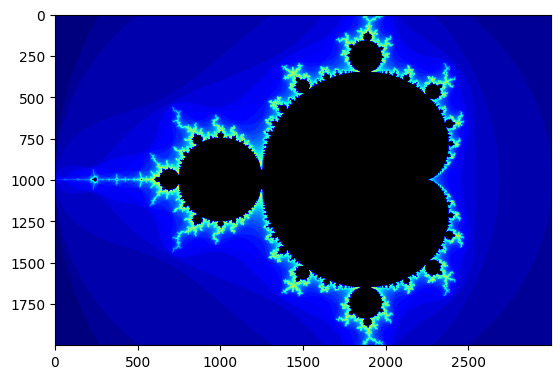

In [13]:
print_fractal_vector(algo_vectorized, -2.0, -1.0, 1.0, 1.0, 3000, 2000, 50)

Mandelbrot created in 58.535001 s


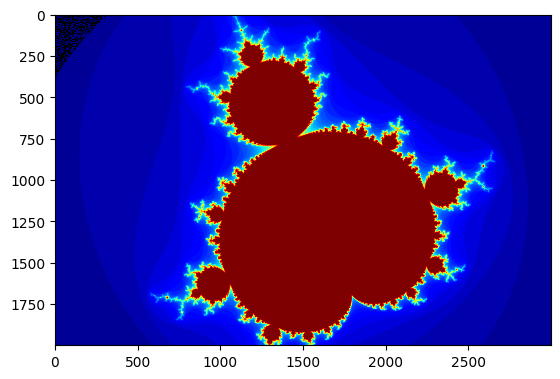

In [14]:
print_fractal_complex(algo_naive, -2.0 + 1j, 1.0 - 1j, 3000, 2000, 50)

In [22]:
if __name__ == "__main__":
    x_min, x_max = -2.0, 1.0
    y_min, y_max = -1.0, 1.0
    width, height = 800, 600
    max_iter = 256
    s = timer()

    mandelbrot_set = NumbaCuda().compute_grid(x_min, y_min, x_max, y_max, width, height, max_iter)

    e = timer()
    print("Execution time: %f seconds" % (e - s))

    imshow(mandelbrot_set)
    show()

TypingError: Failed in cuda mode pipeline (step: nopython frontend)
Untyped global name 'self': Cannot determine Numba type of <class 'mandelbrot_lib.algorithms.numba_cuda.NumbaCuda'>

File "../mandelbrot_lib/mandelbrot_lib/algorithms/numba_cuda.py", line 39:
    def _compute_escape_iter(x: float, y: float, max_iter: int) -> int:
        <source elided>
    @staticmethod
    @cuda.jit
    ^


## Trying to do it without class structure

De ce que j'ai lu sur internet, il n'existe pas encore d'implémentation pour paralléliser des classes, d'où peut être l'erreur ?

In [8]:
from numba import cuda


In [11]:
@cuda.jit(device=True)
def compute_escape_iter(x : float, y : float, max_iter: int) -> np.ndarray:
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iter):
        z = z * z + c
        if z.real * z.real + z.imag * z.imag >= 4:
            return i
    return max_iter

In [12]:
def compute_grid( x_min: float, y_min: float, x_max: float, y_max: float, width: int, height: int, max_iter: int) -> np.ndarray:
    results = np.zeros((height, width), dtype=np.int32)

    # Define grid and block dimensions
    nthreads = 16
    blockspergrid_x = (width + nthreads - 1) // nthreads
    blockspergrid_y = (height + nthreads - 1) // nthreads

    @cuda.jit
    def compute_grid_kernel(x_min: float, y_min: float, x_max: float, y_max: float, width: int, height: int, max_iter: int, results: np.ndarray):
        pixel_size_x = (x_max - x_min) / width
        pixel_size_y = (y_max - y_min) / height
        x, y = cuda.grid(2)
        if x < width and y < height:
            real = x_min + x * pixel_size_x
            imag = y_min + y * pixel_size_y
            results[y, x] = compute_escape_iter(real, imag, max_iter)

    compute_grid_kernel[(blockspergrid_x, blockspergrid_y), (nthreads, nthreads)](x_min, y_min, x_max, y_max, width, height, max_iter, results)
    return results


/home/onyxia/.cache/pypoetry/virtualenvs/mandelbrot-lib-9exWkV6_-py3.12/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Execution time: 0.149945 seconds


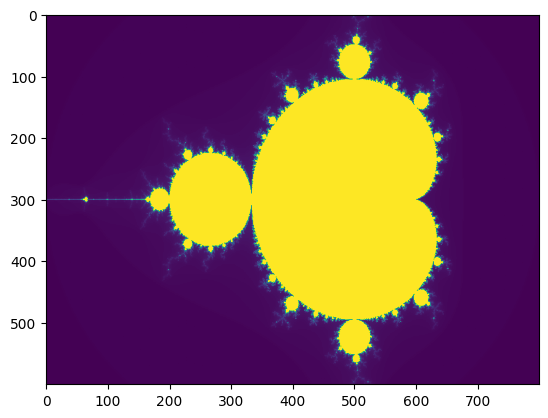

In [16]:
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.0, 1.0
width, height = 800, 600
max_iter = 256
s = timer()

mandelbrot_set = compute_grid(x_min, y_min, x_max, y_max, width, height, max_iter)

e = timer()
print("Execution time: %f seconds" % (e - s))

plt.imshow(mandelbrot_set)
plt.show()